# Импорт библиотек

In [1]:
# импорты библиотек
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle
import random

import torch

print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data.dataloader import default_collate
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.metrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import mlflow

1.8.1+cu101


# Гиперпараметры

In [2]:
# Гиперпараметры
INPUT_SIZE = 23
HIDDEN_SIZE = 25
OUTPUT_SIZE = 5
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 256
EMBEDDING_SIZE = 5

# Подключение логирования 

In [3]:
# Подключаем логгирование
train_writer = SummaryWriter('./logs/train')
valid_writer = SummaryWriter('./logs/valid')

# Train & Test Split

In [4]:
# Разделение датасета на трейн и тест и сохранение в pickle формат
X = pd.read_csv('./data/X_cat.csv', sep='\t', index_col=0)
target = pd.read_csv('./data/y_cat.csv', sep='\t', index_col=0, names=['status'])  # header=-1,

X_train, X_test, y_train, y_test = train_test_split(X, target,
                                                    test_size=0.2, stratify=target, random_state=42)

print('Size of train set: ', len(X_train))
print('Size of test set: ', len(X_test))

with open('./data/X_train_cat.pickle', 'wb') as f:
    pickle.dump((X_train, y_train), f)

with open('./data/X_test_cat.pickle', 'wb') as f:
    pickle.dump((X_test, y_test), f)

Size of train set:  21383
Size of test set:  5346


In [5]:
X_train

,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
12647,0,30.0,0,7,0.285871,0,0.031086,0.034713,1,1,...,0,1,0,0,1,0,0,0,0,0
16303,0,28.0,1,4,0.000105,0,0.085505,0.199270,0,1,...,0,1,0,1,0,0,0,0,0,0
3792,0,28.0,0,7,0.285871,0,0.061778,0.164522,1,1,...,0,1,0,0,0,0,0,0,1,0
13021,1,730.0,1,6,0.000419,1,0.025822,0.274622,0,1,...,1,0,0,1,0,0,0,0,0,0
4295,0,60.0,0,7,0.285871,1,0.000026,0.035523,1,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13057,1,1825.0,1,4,0.000419,0,0.034909,0.299102,0,0,...,1,0,0,0,1,0,0,0,0,0
19635,1,60.0,1,9,0.000026,1,0.000655,0.204352,0,1,...,1,0,0,1,0,0,0,0,0,0
13299,1,2.0,0,7,0.285871,0,0.005369,0.012766,0,1,...,0,1,0,0,0,0,0,0,1,0
12045,0,1095.0,0,7,0.285871,1,0.026293,0.357521,0,1,...,0,0,1,1,0,0,0,0,0,0


# Feature engineering

Попробуем провести небольшой EDA, чтобы понять, какие преобразования будем делать с фичами в классе CustomDataset

## Корреляция признаков

Посмотрим на корреляцию признаков

In [6]:
df_train = X_train
y_train[y_train == 'Died'] = 'Euthanasia'
y_test[y_test == 'Died'] = 'Euthanasia'
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
df_train['target'] = y_train

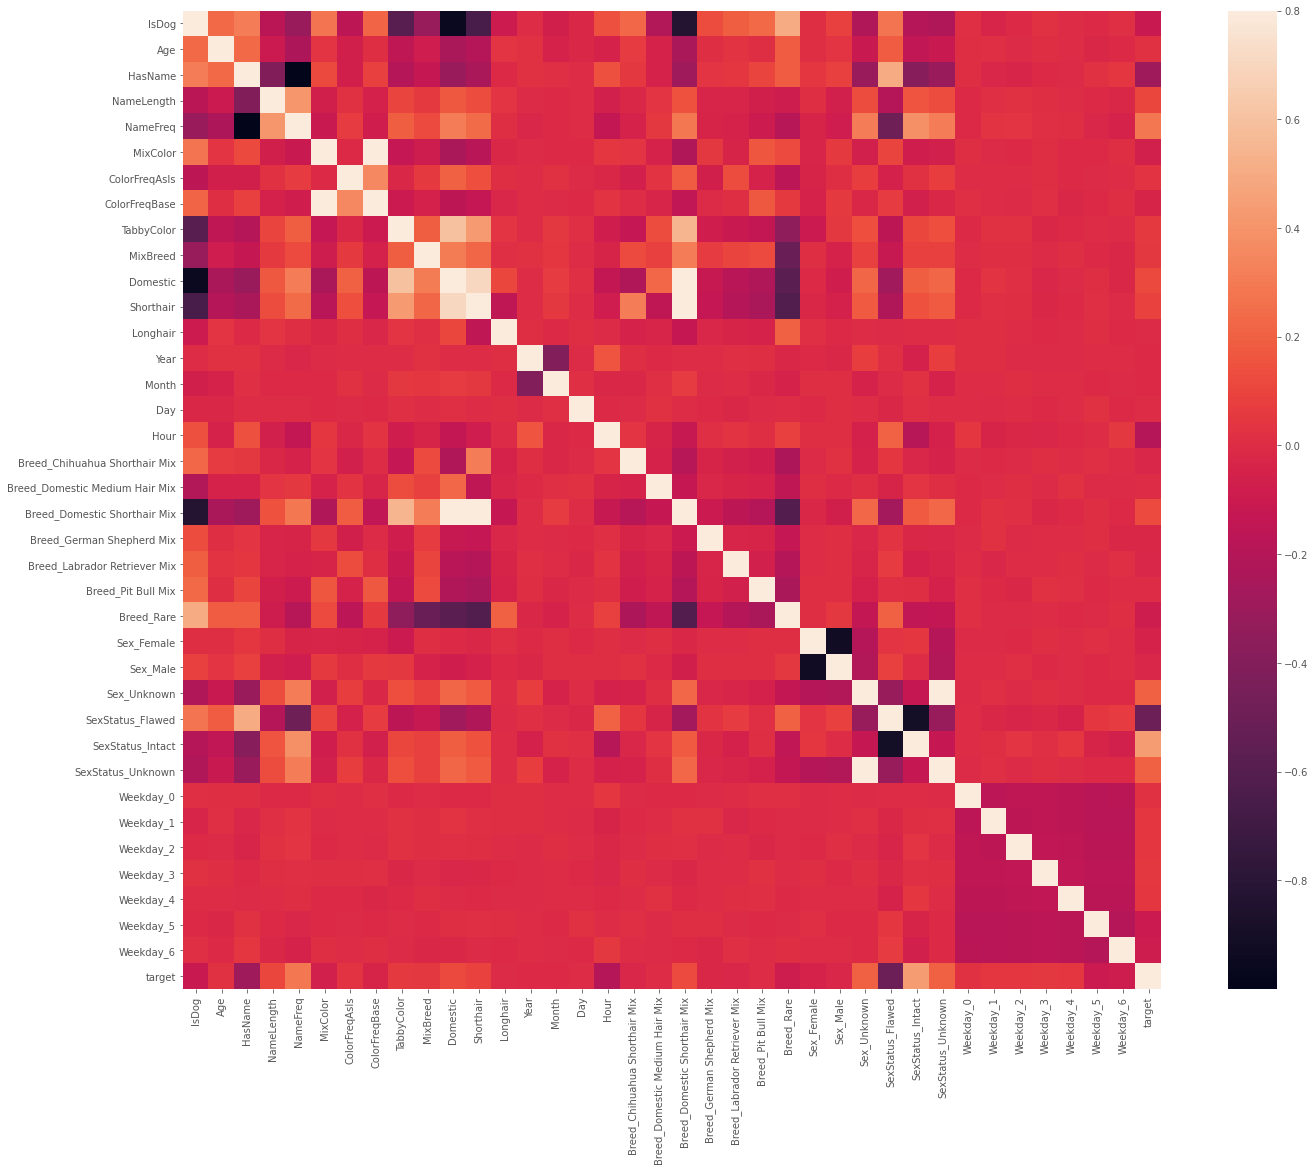

In [7]:
#Строим корреляционную матрицу признаков
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corrmat, vmax=.8, square=True);

Теперь посмотрим 10 наиболее скореллированных признаков

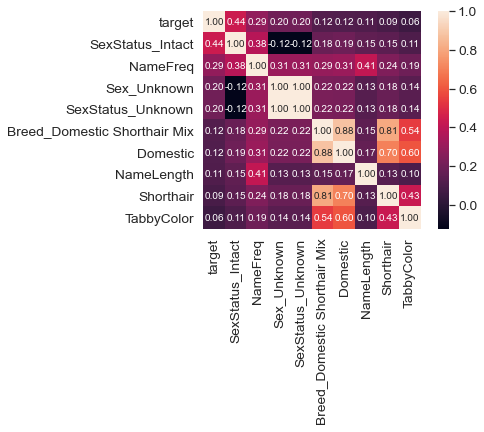

In [8]:
# Теперь посмотрим 10 наиболее скореллированных признаков
k = 10 
cols = corrmat.nlargest(k, 'target')['target'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Из корреляционной матрицы можно заметить, что признак Breed_Domestic Shorthair Mix сильно коррелирует с 3мя признаками, можно его удалить.
Также единичная корреляция у признаков SexStatus_Unknown и Sex_Unknown, это похоже на пропущенное значение, можно попробовать их заменить на медианные значения

##  Разброс значений

Посмотрим на статистики признаков с помощью функции describe в пандасе

In [9]:
pd.set_option('display.max_columns', None)
df_train.describe()

,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,Domestic,Shorthair,Longhair,Year,Month,Day,Hour,Breed_Chihuahua Shorthair Mix,Breed_Domestic Medium Hair Mix,Breed_Domestic Shorthair Mix,Breed_German Shepherd Mix,Breed_Labrador Retriever Mix,Breed_Pit Bull Mix,Breed_Rare,Sex_Female,Sex_Male,Sex_Unknown,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,target
count,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000,21383.000000
mean,0.584717,789.296784,0.710798,5.996259,0.083109,0.524622,0.035809,0.257993,0.193518,0.835196,0.388299,0.427396,0.029743,2014.426367,6.938269,15.731001,11.787944,0.066642,0.030912,0.328953,0.022027,0.050554,0.071318,0.429594,0.460974,0.497919,0.041107,0.696301,0.262592,0.041107,0.137913,0.143291,0.131179,0.126362,0.133190,0.165786,0.162278,1.481130
std,0.492782,1075.830729,0.453402,1.545368,0.129340,0.499405,0.033210,0.172789,0.395065,0.371012,0.487375,0.494712,0.169882,0.742808,3.491980,8.777146,3.110817,0.249406,0.173084,0.469844,0.146774,0.219091,0.257362,0.495030,0.498486,0.500007,0.198543,0.459865,0.440053,0.198543,0.344817,0.350378,0.337604,0.332265,0.339788,0.371897,0.368715,1.326823
min,0.000000,1.000000,0.000000,1.000000,0.000026,0.000000,0.000026,0.000086,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,60.000000,0.000000,5.000000,0.000105,0.000000,0.012413,0.075353,0.000000,1.000000,0.000000,0.000000,0.000000,2014.000000,4.000000,8.000000,9.541667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,365.000000,1.000000,6.000000,0.000602,1.000000,0.024748,0.274622,0.000000,1.000000,0.000000,0.000000,0.000000,2014.000000,7.000000,16.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1095.000000,1.000000,7.000000,0.285871,1.000000,0.061778,0.463624,0.000000,1.000000,1.000000,1.000000,0.000000,2015.000000,10.000000,23.000000,14.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,7300.000000,1.000000,12.000000,0.285871,1.000000,0.105879,0.598205,1.000000,1.000000,1.000000,1.000000,1.000000,2016.000000,12.000000,31.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


Видим что большой максимум у переменной Age. Можно нормировать. Посмотрим на ее распределение

<AxesSubplot:>

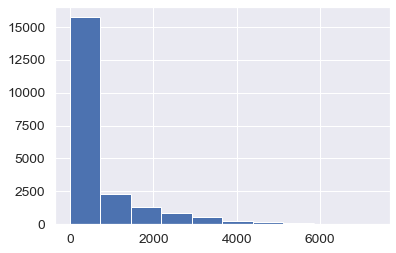

In [10]:
df_train['Age'].hist()

Видим смещение.Линейные модели любят нормальное распределение. Сделаем данное распределение более похожим на нормальное, например, логарифмируя его:

<AxesSubplot:>

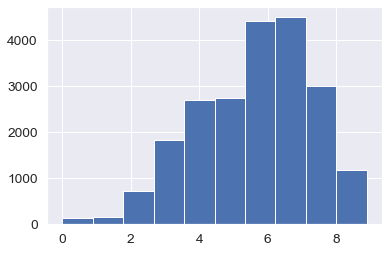

In [11]:
np.log(df_train['Age']).hist()

Так-то лучше. Как видим размерность значений уменьшилась. Были тысячи, теперь макс значение не превышает десяти

## Категориальные признаки

Посмотрим на породы

# Feature Selection

Еще как вариант можно с помощью алгоритмов, таких как XGboost отранжировать фичи по объясняющей способности, и те фичи, у которых объясняющая способность будет ниже некоего порога, мы удалим. В качестве примера возьмем Xgboost и используем его для получения feature importances, ну и посмотрим предсказания y_pred для интереса. Значения можно не нормировать так как xgboost не чувствителен к большим разбросам.

In [12]:
xgb = XGBClassifier(n_estimators=1000)
xgb.fit(df_train.drop('target', axis=1), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
y_pred = xgb.predict(X_test)

Точность Xgboost'а:

In [14]:
accuracy = Accuracy()
accuracy(torch.tensor(y_pred), torch.tensor(y_test))

tensor(0.6831)

Как видим сам по себе Xgboost уже выдает неплохой результат, однако попробуем использовать его для Feature Selection в нашей учебной нейросети

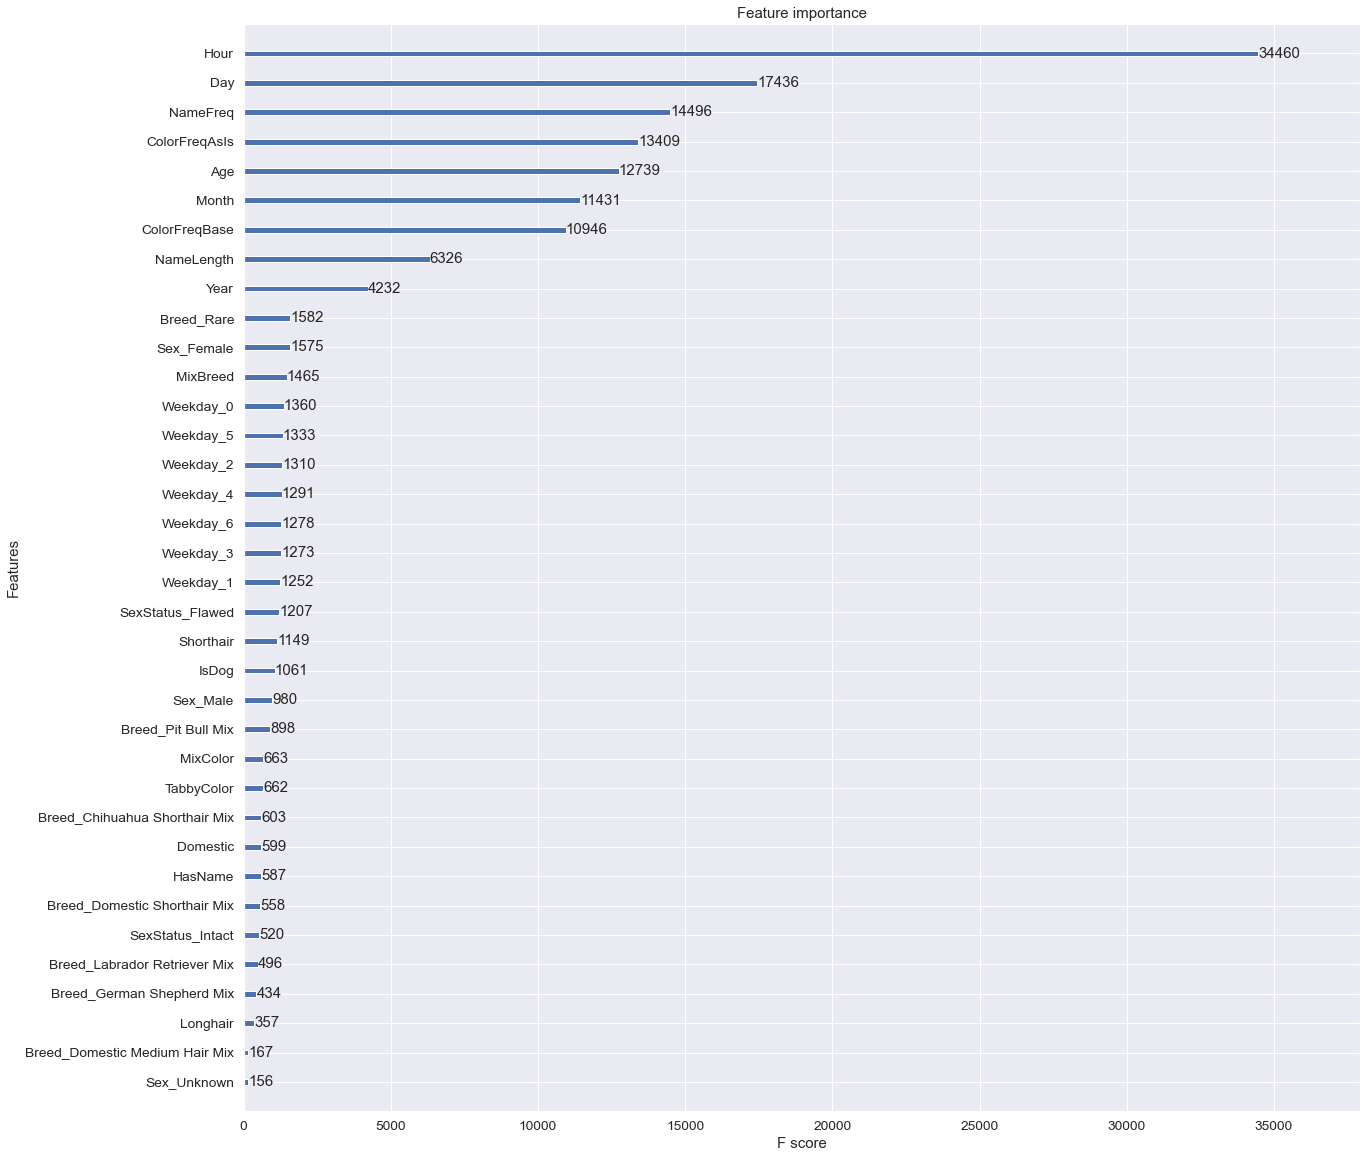

In [15]:
ax = plot_importance(xgb)
fig = ax.figure
fig.set_size_inches(20, 20)

Визуально видно,что наилучшими объясняющими способностями обладают признаки Hour, Day, NameFreq, ColorFreqAsIs, Age, Month, ColorFreqBase, NameLength, Year. Можно попробовать поэкспериментировать с пороговым значением feature importances для отбора нужных нам признаков. 

На этом я считаю можно завершить EDA и на его основе пробовать поиграться с фичами.

# Custom Dataloader

In [16]:
class CustomDataset(Dataset):
    # Конструктор, где считаем датасет
    def __init__(self, dataset_path):
        
        with open(dataset_path, 'rb') as f:
            X, target = pickle.load(f)
        

        weekday_columns = ['Weekday_0', 'Weekday_1', 'Weekday_2',
                           'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6']
        weekdays = np.argmax(X[weekday_columns].values, axis=1)

        X.drop(weekday_columns, axis=1, inplace=True)

        
        X['Weekday_cos'] = np.cos(2 * np.pi / 7.) * weekdays
        X['Weekday_sin'] = np.sin(2 * np.pi / 7.) * weekdays

        X['Hour_cos'] = np.cos(2 * np.pi / 24.) * X['Hour'].values
        X['Hour_sin'] = np.sin(2 * np.pi / 24.) * X['Hour'].values

        X['Month_cos'] = np.cos(2 * np.pi / 12.) * X['Month'].values
        X['Month_sin'] = np.sin(2 * np.pi / 12.) * X['Month'].values
        
        X['Day_cos'] = np.cos(2 * np.pi / 31.) * X['Day'].values
        X['Day_sin'] = np.sin(2 * np.pi / 31.) * X['Day'].values
        
        # Логарифмируем возраст для того, чтобы сделать распределение более похожим на нормальное и снизить размерность
        X['Age_log'] = np.log(X['Age'])
        
        

        X['Gender'] = np.argmax(X[['Sex_Female', 'Sex_Male', 'Sex_Unknown']].values, axis=1)

        X.drop(['Sex_Female', 'Sex_Male', 'Sex_Unknown'], axis=1, inplace=True)
         
        # Заменяем значения Sex_Unknown случайным выбором пола с вероятностью p     
        p_male = X[X['Gender'] != 2]['Gender'].mean()
        X[X['Gender'] == 2]['Gender'] = random.choices([0,1], weights=[1-p_male, p_male], k=len(X[X['Gender'] == 2]['Gender']))
        
        
        X['SexStatus'] = np.argmax(X[['SexStatus_Flawed', 'SexStatus_Intact', 'SexStatus_Unknown']].values, axis=1)

        X.drop(['SexStatus_Flawed', 'SexStatus_Intact', 'SexStatus_Unknown'], axis=1, inplace=True)
        
        # Заменяем значения SexStatus_Unknown случайным выбором пола с вероятностью p   
        p_intact = X[X['SexStatus'] != 2]['SexStatus'].mean()
        X[X['SexStatus'] == 2]['SexStatus'] = random.choices([0,1], weights=[1-p_intact, p_intact],k=len(X[X['SexStatus'] == 2]['SexStatus']))
        
        
        
        
        

        print(X.shape)
        print(X.head())

        target = target.iloc[:, :].values
        target[target == 'Died'] = 'Euthanasia'

        le = LabelEncoder()
        self.y = le.fit_transform(target)

        self.X = X.values

        self.columns = X.columns.values

#         Почему то код ломается, когда я пишу в self.embedding_column больше одного значения
#         self.embedding_column = ['Gender', 'SexStatus', 'IsDog', 'Shorthair', 'Breed_Rare']
#         Эти фичи я поместил в self.numeric columns, у них все равно только 2 категории и эмбеддинги под них можно не создавать
        self.embedding_column = 'Gender'
        self.nrof_emb_categories = 3
        self.numeric_columns = ['NameFreq', 'ColorFreqAsIs', 'Age_log', 'ColorFreqBase', 
                                'NameLength', 'Year', 'Day_cos','Day_sin', 'Weekday_cos','Weekday_sin', 
                                'Hour_cos','Hour_sin', 'Month_cos', 'Month_sin','SexStatus', 'IsDog', 'Shorthair', 'Breed_Rare']
        
        return

    def __len__(self):
        return len(self.X)

    # Переопределяем метод,
    # который достает по индексу наблюдение из датасет
    def __getitem__(self, idx):

        row = self.X[idx, :]

        row = {col: torch.tensor(row[i]) for i, col in enumerate(self.columns)}

        return row, self.y[idx]

In [17]:
class CustomSampler(Sampler):

    # Конструктор, где инициализируем индексы элементов
    def __init__(self, data):
        self.data_indices = np.arange(len(data))

        shuffled_indices = np.random.permutation(len(self.data_indices))

        self.data_indices = np.ascontiguousarray(self.data_indices)[shuffled_indices]

        return

    def __len__(self):
        return len(self.data_indices)

    # Возращает итератор,
    # который будет возвращать индексы из перемешанного датасета
    def __iter__(self):
        return iter(self.data_indices)

In [18]:
def collate(batch):
    return default_collate(batch)

# MLP Net

In [19]:
class MLPNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, nrof_cat, emb_dim,
                 emb_columns, numeric_columns):
        super(MLPNet, self).__init__()
        self.emb_columns = emb_columns
        self.numeric_columns = numeric_columns

        self.emb_layer = torch.nn.Embedding(nrof_cat, emb_dim)

        self.feature_bn = torch.nn.BatchNorm1d(input_size)

        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear1.apply(self.init_weights)
        self.bn1 = torch.nn.BatchNorm1d(hidden_size)

        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear2.apply(self.init_weights)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size)
        
        self.linear3 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear3.apply(self.init_weights)
        self.bn3 = torch.nn.BatchNorm1d(hidden_size)
        
        
        self.linear4 = torch.nn.Linear(hidden_size, output_size)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            # m.bias.data.fill_(0.001)

    def forward(self, x):
        emb_output = self.emb_layer(torch.tensor(pd.DataFrame(x)[self.emb_columns].values, dtype=torch.int64))
        numeric_feats = torch.tensor(pd.DataFrame(x)[self.numeric_columns].values, dtype=torch.float32)
 
        concat_input = torch.cat([numeric_feats, emb_output], dim=1)
        output = self.feature_bn(concat_input)

        output = self.linear1(output)
        output = self.bn1(output)
        output = torch.relu(output)

        output = self.linear2(output)
        output = self.bn2(output)
        output = torch.relu(output)
        
        output = self.linear3(output)
        output = self.bn3(output)
        output = torch.relu(output)  
        

        output = self.linear4(output)
        logits = output

        return logits

In [20]:
def run_train(model, train_loader, test_loader):
    step = 0
    for epoch in range(EPOCHS):
        model.train()

        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label.long())
            loss.backward()
            acc = accuracy(torch.softmax(output, dim=1), label.long()).item()

            # Update weights with gradients
            optimizer.step()
            
            train_writer.add_scalar('CrossEntropyLoss', loss, step)
            train_writer.add_scalar('Accuracy', acc, step)

            step += 1

            if step % 100 == 0:
                print('EPOCH %d STEP %d : train_loss: %f train_acc: %f' %
                      (epoch, step, loss.item(), acc))
        
        train_writer.add_histogram('hidden_layer', model.linear1.weight.data, step)

        
        # Run validation
        running_loss = []
        valid_scores = []
        valid_labels = []
        model.eval()
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                # Calculate error and backpropagate
                loss = criterion(output, label.long())

                running_loss.append(loss.item())
                valid_scores.extend(torch.argmax(output, dim=1))
                valid_labels.extend(label.long())

        valid_accuracy = accuracy(torch.tensor(valid_scores), torch.tensor(valid_labels)).item()

        valid_writer.add_scalar('CrossEntropyLoss', np.mean(running_loss), step)
        valid_writer.add_scalar('Accuracy', valid_accuracy, step)

        print('EPOCH %d : valid_loss: %f valid_acc: %f' % (epoch, np.mean(running_loss), valid_accuracy))
        
    return step

In [21]:
# Функция создания train и test даталоадера
def create_data_loader(train_dataset, train_sampler,
                       test_dataset, test_sampler):
    train_loader = DataLoader(dataset=train_dataset, sampler=train_sampler,
                              batch_size=BATCH_SIZE, collate_fn=collate,
                              shuffle=False)

    test_loader = DataLoader(dataset=test_dataset, sampler=test_sampler,
                             batch_size=BATCH_SIZE, collate_fn=collate,
                             shuffle=False)

    return train_loader, test_loader

In [22]:
# Создание train даталоадера и test даталоадера
train_ds = CustomDataset('./data/X_train_cat.pickle')
train_sampler = CustomSampler(train_ds.X)

test_ds = CustomDataset('./data/X_test_cat.pickle')
test_sampler = CustomSampler(test_ds.X)

train_loader, test_loader = create_data_loader(train_ds, train_sampler,
                                               test_ds, test_sampler)

(21383, 35)
       IsDog    Age  HasName  NameLength  NameFreq  MixColor  ColorFreqAsIs  \
12647      0   30.0        0           7  0.285871         0       0.031086   
16303      0   28.0        1           4  0.000105         0       0.085505   
3792       0   28.0        0           7  0.285871         0       0.061778   
13021      1  730.0        1           6  0.000419         1       0.025822   
4295       0   60.0        0           7  0.285871         1       0.000026   

       ColorFreqBase  TabbyColor  MixBreed  Domestic  Shorthair  Longhair  \
12647       0.034713           1         1         1          1         0   
16303       0.199270           0         1         1          1         0   
3792        0.164522           1         1         1          1         0   
13021       0.274622           0         1         0          0         0   
4295        0.035523           1         1         1          1         0   

       Year  Month  Day       Hour  Breed_Chihuahu

In [23]:
model = MLPNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, train_ds.nrof_emb_categories,
               EMBEDDING_SIZE,
               train_ds.embedding_column, train_ds.numeric_columns)

criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
train_writer.add_text('LEARNING_RATE', str(LEARNING_RATE))
train_writer.add_text('INPUT_SIZE', str(INPUT_SIZE))
train_writer.add_text('HIDDEN_SIZE', str(HIDDEN_SIZE))
train_writer.add_text('NROF_CLASSES', str(OUTPUT_SIZE))
train_writer.add_text('BATCH_SIZE', str(BATCH_SIZE))

# При добавлении графа в tensorboard код ломается по неизвестной мне причине
# train_writer.add_graph(model, torch.tensor(X_test.astype(np.float32)), verbose=True)

In [25]:
step = run_train(model, train_loader, test_loader)

EPOCH 0 : valid_loss: 0.843147 valid_acc: 0.650580
EPOCH 1 STEP 100 : train_loss: 0.802426 train_acc: 0.652344
EPOCH 1 : valid_loss: 0.812753 valid_acc: 0.666667
EPOCH 2 STEP 200 : train_loss: 0.800861 train_acc: 0.667969
EPOCH 2 : valid_loss: 0.802311 valid_acc: 0.669660
EPOCH 3 STEP 300 : train_loss: 0.712249 train_acc: 0.722656
EPOCH 3 : valid_loss: 0.801549 valid_acc: 0.672652
EPOCH 4 STEP 400 : train_loss: 0.768600 train_acc: 0.687500
EPOCH 4 : valid_loss: 0.798247 valid_acc: 0.672840
EPOCH 5 STEP 500 : train_loss: 0.799204 train_acc: 0.636719
EPOCH 5 : valid_loss: 0.797173 valid_acc: 0.672278
EPOCH 6 : valid_loss: 0.795214 valid_acc: 0.674336
EPOCH 7 STEP 600 : train_loss: 0.779333 train_acc: 0.667969
EPOCH 7 : valid_loss: 0.792988 valid_acc: 0.671530
EPOCH 8 STEP 700 : train_loss: 0.736525 train_acc: 0.695312
EPOCH 8 : valid_loss: 0.793362 valid_acc: 0.673588
EPOCH 9 STEP 800 : train_loss: 0.722791 train_acc: 0.687500
EPOCH 9 : valid_loss: 0.792562 valid_acc: 0.673962
EPOCH 10 S

# Вывод

Проведя Feature Engineering и обучение многослойного перцептрона можно сказать, что нейросеть в целом показала себя молодцом, но с течением времени начала переобучаться, и в точности у xgboost'а ,увы, не выиграла.